In [44]:
import matplotlib.pyplot as plt
from pyspark import SparkFiles
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col, split, explode, regexp_replace, lower, count
import pandas as pd

In [2]:
spark = SparkSession.builder.appName("MySparkApp").getOrCreate()

In [3]:
spark.sparkContext.addFile("https://www.gutenberg.org/cache/epub/1513/pg1513.txt")

### Separate the words: The DataFrame will start with one line of text per row. Split out the words into one word per row.

In [4]:
romeo_juliet_df = spark.read.text(SparkFiles.get("pg1513.txt"))
romeo_juliet_df.show()

+--------------------+
|               value|
+--------------------+
|The Project Guten...|
|                    |
|This ebook is for...|
|most other parts ...|
|whatsoever. You m...|
|of the Project Gu...|
|at www.gutenberg....|
|you will have to ...|
|before using this...|
|                    |
|Title: Romeo and ...|
|                    |
|Author: William S...|
|                    |
|Release date: Nov...|
|                M...|
|                    |
|   Language: English|
|                    |
|Credits: the PG S...|
+--------------------+
only showing top 20 rows



In [5]:
words_df = romeo_juliet_df.select(explode(split(col("value"), r"\s+")).alias("word"))

In [6]:
words_df.show(20, truncate=False)

+---------+
|word     |
+---------+
|The      |
|Project  |
|Gutenberg|
|eBook    |
|of       |
|Romeo    |
|and      |
|Juliet   |
|         |
|         |
|This     |
|ebook    |
|is       |
|for      |
|the      |
|use      |
|of       |
|anyone   |
|anywhere |
|in       |
+---------+
only showing top 20 rows



### Punctuation: Remove punctuation from the grouped word counts (e.g. “way.” becomes “way”). This should happen prior to grouping words. (Hint: regular expressions can be helpful here.)


In [7]:
#View punctuation marks
chars_df = romeo_juliet_df.select(explode(split(col("value"), "")).alias("char"))


In [8]:
# Keep only non-alphanumerics and non-whitespace
punctuation_df = chars_df.filter(~col("char").rlike(r"[a-zA-Z0-9\s]"))  
unique_punctuations = punctuation_df.distinct().orderBy("char")

In [9]:
unique_punctuations.show(truncate=False)

+----+
|char|
+----+
|    |
|!   |
|#   |
|$   |
|%   |
|&   |
|(   |
|)   |
|*   |
|,   |
|-   |
|.   |
|/   |
|:   |
|;   |
|?   |
|[   |
|]   |
|_   |
|æ   |
+----+
only showing top 20 rows



In [10]:
cleaned_df = romeo_juliet_df.select(
    regexp_replace(col("value"), r"[^\w\s]", "").alias("cleaned_line")
)

In [11]:
cleaned_df.show()

+--------------------+
|        cleaned_line|
+--------------------+
|The Project Guten...|
|                    |
|This ebook is for...|
|most other parts ...|
|whatsoever You ma...|
|of the Project Gu...|
|at wwwgutenbergor...|
|you will have to ...|
|before using this...|
|                    |
|Title Romeo and J...|
|                    |
|Author William Sh...|
|                    |
|Release date Nove...|
|                M...|
|                    |
|    Language English|
|                    |
|Credits the PG Sh...|
+--------------------+
only showing top 20 rows



### Word Counts:
Total word count: Output the total word count summarizing all plays.

Grouped word count: Group and tally each word present amongst all plays combined. Sort with the most frequent words first.


In [21]:
spark = SparkSession.builder.appName("ShakespeareWordCount").getOrCreate()

In [18]:
files = [
    ("Romeo and Juliet", "https://www.gutenberg.org/cache/epub/1513/pg1513.txt"),
    ("The Tempest", "https://www.gutenberg.org/cache/epub/23042/pg23042.txt"),
    ("Hamlet", "https://www.gutenberg.org/cache/epub/27761/pg27761.txt"),
    ("Macbeth", "https://www.gutenberg.org/cache/epub/1533/pg1533.txt"),
    ("Othello", "https://www.gutenberg.org/cache/epub/1531/pg1531.txt")
]

In [19]:
dataframes = {}
for title, url in files:
    # Add file to Spark
    spark.sparkContext.addFile(url)
    #Extract file name
    file_path = SparkFiles.get(url.split("/")[-1])  
    # Read file into DataFrame
    df = spark.read.text(file_path)
    dataframes[title] = df
    print(f"Loaded '{title}' into DataFrame.")

Loaded 'Romeo and Juliet' into DataFrame.
Loaded 'The Tempest' into DataFrame.
Loaded 'Hamlet' into DataFrame.
Loaded 'Macbeth' into DataFrame.
Loaded 'Othello' into DataFrame.


In [20]:
for title, df in dataframes.items():
    print(f"\nFirst 5 rows of '{title}':")
    df.show(5, truncate=True)


First 5 rows of 'Romeo and Juliet':
+--------------------+
|               value|
+--------------------+
|The Project Guten...|
|                    |
|This ebook is for...|
|most other parts ...|
|whatsoever. You m...|
+--------------------+
only showing top 5 rows


First 5 rows of 'The Tempest':
+--------------------+
|               value|
+--------------------+
|The Project Guten...|
|                    |
|This ebook is for...|
|most other parts ...|
|whatsoever. You m...|
+--------------------+
only showing top 5 rows


First 5 rows of 'Hamlet':
+--------------------+
|               value|
+--------------------+
|The Project Guten...|
|                    |
|This ebook is for...|
|most other parts ...|
|whatsoever. You m...|
+--------------------+
only showing top 5 rows


First 5 rows of 'Macbeth':
+--------------------+
|               value|
+--------------------+
|The Project Guten...|
|                    |
|This ebook is for...|
|most other parts ...|
|whatsoever. You m.

In [33]:
#Load and clean text
def load_and_clean_text(url):
    spark.sparkContext.addFile(url)
    file_path = SparkFiles.get(url.split("/")[-1])  # Extract filename
    df = spark.read.text(file_path)
    
    # Clean text: remove punctuation, lowercase, split into words, and filter non-words
    words_df = df.select(
        explode(
            split(
                regexp_replace(lower(col("value")), r"[^\w\s]", ""),  # Remove punctuation
                r"\s+"  # Split on whitespace
            )
        ).alias("word")
    ).filter(col("word").rlike(r"^\w+$"))  # Keep only valid words
    return words_df


In [29]:
total_word_count = 0
for title, url in files:
    words_df = load_and_clean_text(title, url)
    word_count = words_df.count()
    total_word_count += word_count
    print(f"The word count for '{title}' is {word_count}")

The word count for 'Romeo and Juliet' is 28989
The word count for 'The Tempest' is 26415
The word count for 'Hamlet' is 34879
The word count for 'Macbeth' is 21417
The word count for 'Othello' is 30966


In [34]:
print(f"The fotal word count across all plays: {total_word_count}")


The fotal word count across all plays: 142666


In [35]:
#Combine all plays into a single DataFrame
all_words_df = None
for _, url in files:
    words_df = load_and_clean_text(url)
    if all_words_df is None:
        all_words_df = words_df
    else:
        all_words_df = all_words_df.union(words_df)

In [36]:
grouped_word_count_df = (
    all_words_df.groupBy("word")  # Group by word
    .agg(count("word").alias("count"))  # Count occurrences
    .orderBy(col("count").desc())  # Sort by count in descending order
)

In [37]:
grouped_word_count_df.show(20, truncate=False)

+----+-----+
|word|count|
+----+-----+
|the |5053 |
|and |3737 |
|to  |3031 |
|of  |2979 |
|i   |2667 |
|a   |2430 |
|you |2000 |
|in  |1880 |
|my  |1661 |
|that|1550 |
|is  |1466 |
|not |1307 |
|it  |1265 |
|with|1256 |
|this|1225 |
|for |1054 |
|be  |1001 |
|me  |1000 |
|but |843  |
|as  |832  |
+----+-----+
only showing top 20 rows



In [38]:
pandas_df = grouped_word_count_df.toPandas()

In [46]:
pandas_df = pandas_df.head(50)

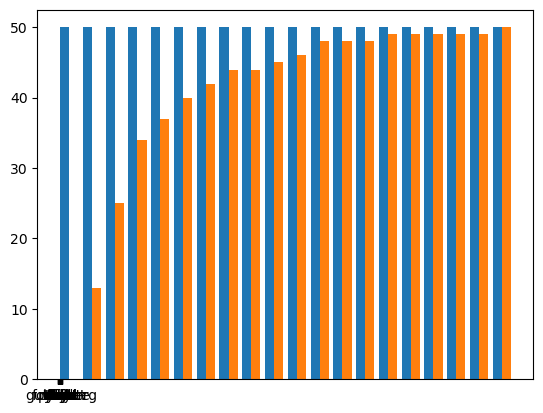

In [47]:
plt.hist(pandas_df, bins=20, cumulative= True )
plt.show()